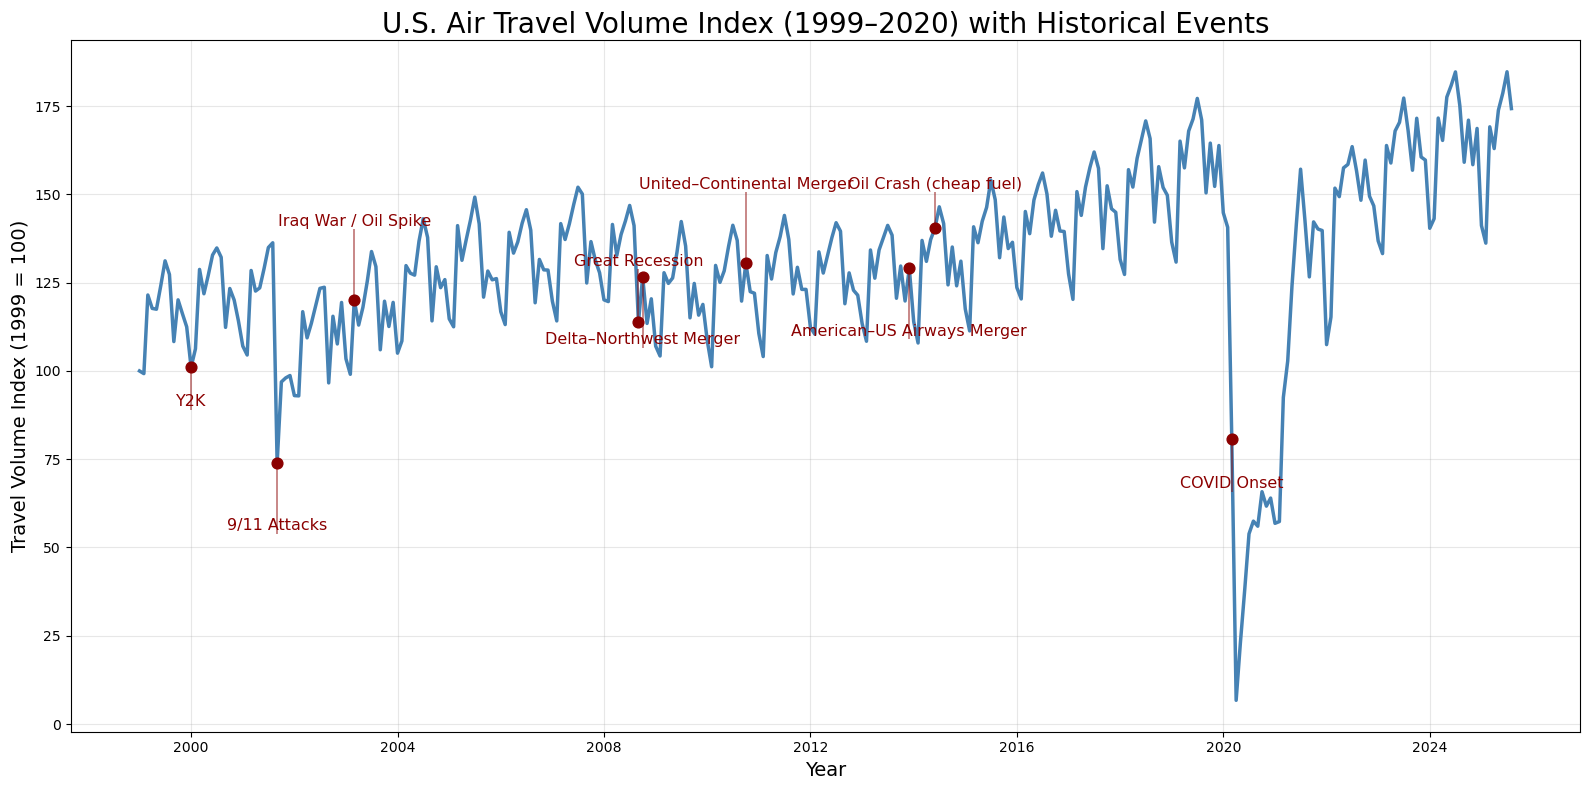

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# -----------------------------
# Load & prepare dataset
# -----------------------------
df = pd.read_json("webpage_deliverable/data/monthly_metrics.json")

# Create unified datetime column
df["date"] = pd.to_datetime(df[["YEAR", "MONTH"]].assign(DAY=1))

# Sum all sectors (Domestic + International + Unknown)
df_total = df.groupby("date")["PASSENGERS"].sum().reset_index()

# Normalize to create "volume index" (1999 start = 100)
base = df_total["PASSENGERS"].iloc[0]
df_total["volume_index"] = (df_total["PASSENGERS"] / base) * 100

# -----------------------------
# Historical events
# -----------------------------
events = {
    "Y2K": "2000-01-01",
    "9/11 Attacks": "2001-09-01",
    "Iraq War / Oil Spike": "2003-03-01",
    "Great Recession": "2008-09-01",
    "Delta–Northwest Merger": "2008-10-01",
    "United–Continental Merger": "2010-10-01",
    "American–US Airways Merger": "2013-12-01",
    "Oil Crash (cheap fuel)": "2014-06-01",
    "COVID Onset": "2020-03-01"
}

# Convert to datetime objects
events = {label: datetime.strptime(date, "%Y-%m-%d") for label, date in events.items()}

# -----------------------------
# Offsets to avoid overlap
# -----------------------------
offsets = {
    "Y2K": -12,
    "9/11 Attacks": -20,
    "Iraq War / Oil Spike": 20,
    "Great Recession": 15,
    "Delta–Northwest Merger": -20,
    "United–Continental Merger": 20,
    "American–US Airways Merger": -20,
    "Oil Crash (cheap fuel)": 10,
    "COVID Onset": -15
}

# -----------------------------
# Create the plot
# -----------------------------
plt.figure(figsize=(16, 8))

# Trend line
plt.plot(df_total["date"], df_total["volume_index"], linewidth=2.5, color="steelblue")
plt.title("U.S. Air Travel Volume Index (1999–2020) with Historical Events", fontsize=20)
plt.ylabel("Travel Volume Index (1999 = 100)", fontsize=14)
plt.xlabel("Year", fontsize=14)

plt.grid(alpha=0.3)

# -----------------------------
# Add event markers + labels
# -----------------------------
for label, date in events.items():
    # Find closest y-value
    y_val = df_total.loc[df_total["date"] == date, "volume_index"]
    if not y_val.empty:
        y = y_val.values[0]

        # Marker
        plt.scatter(date, y, color="darkred", s=60, zorder=5)

        # Guide line up/down to text label
        plt.vlines(date, y, y + offsets[label], color="darkred", linewidth=1.2, alpha=0.55)

        # Label
        plt.text(
            date,
            y + offsets[label] + 1,
            label,
            fontsize=11.5,
            color="darkred",
            ha="center"
        )

# -----------------------------
# Formatting
# -----------------------------
plt.tight_layout()

# Save a PNG (optional)
plt.savefig("annotated_timeline.png", dpi=300, bbox_inches="tight")

plt.show()
